In [239]:
import os


In [240]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
import torch_geometric.nn as pyg_nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Subset
from collections import defaultdict

if torch.backends.mps.is_available():
    print("MPS backend is available!")
else:
    print("MPS backend is not available.")

device = torch.device("mps")

df = pd.read_parquet('stock_data/processed/merged_stock_data_with_enhanced_features.parquet')
df.head()

MPS backend is available!


Automobile and Auto Components                      \
                                              APOLLOTYRE                       
                                                   price return_1d return_5d   
2022-01-10 00:00:00+05:30                     223.718369 -0.002796  0.047097   
2022-01-11 00:00:00+05:30                     223.092926 -0.002796  0.047097   
2022-01-12 00:00:00+05:30                     224.824921  0.007764  0.047097   
2022-01-13 00:00:00+05:30                     226.075821  0.005564  0.047097   
2022-01-14 00:00:00+05:30                     222.852371 -0.014258  0.047097   

                                                                         \
                                                                          
                          return_21d log_return      SMA_20      SMA_50   
2022-01-10 00:00:00+05:30   -0.02086  -0.002800  217.155955  199.445156   
2022-01-11 00:00:00+05:30   -0.02086  -0.002800  217.155955  199.445156   
2022-01-12 00:00:00+05:30   -0.02086   0.007734  217.155955  199.445156   
2022-01-13 00:00:00+05:30   -0.02086   0.005548  217.155955  199.445156   
2022-01-14 00:00:00+05:30   -0.02086  -0.014361  217.155955  199.445156   

                                                               ...  \
                                                               ...   
                               EMA_10      EMA_20      EMA_50  ...   
2022-01-10 00:00:00+05:30  223.718369  223.718369  223.718369  ...   
2022-01-11 00:00:00+05:30  223.604652  223.658803  223.693841  ...   
2022-01-12 00:00:00+05:30  223.826519  223.769861  223.738197  ...   
2022-01-13 00:00:00+05:30  224.235483  223.989477  223.829869  ...   
2022-01-14 00:00:00+05:30  223.984008  223.881181  223.791536  ...   

                                 Textiles                            \
                               WELSPUNLIV                             
                          dist_from_sma50 dist_from_ema20      MACD   
2022-01-10 00:00:00+05:30       -0.189072        0.000000  0.000000   
2022-01-11 00:00:00+05:30       -0.189072       -0.022249 -0.297982   
2022-01-12 00:00:00+05:30       -0.189072       -0.013623 -0.440638   
2022-01-13 00:00:00+05:30       -0.189072        0.009352 -0.257350   
2022-01-14 00:00:00+05:30       -0.189072       -0.007274 -0.321389   

                                                                           \
                                                                            
                          MACD_signal        RSI volatility_20d  BB_width   
2022-01-10 00:00:00+05:30    0.000000  36.533375       0.028095  0.221401   
2022-01-11 00:00:00+05:30   -0.059596  36.533375       0.028095  0.221401   
2022-01-12 00:00:00+05:30   -0.135805  36.533375       0.028095  0.221401   
2022-01-13 00:00:00+05:30   -0.160114  36.533375       0.028095  0.221401   
2022-01-14 00:00:00+05:30   -0.192369  36.533375       0.028095  0.221401   

                                                                      
                                                                      
                          ema_cross_signal is_month_end return_ratio  
2022-01-10 00:00:00+05:30                0            0    -0.024534  
2022-01-11 00:00:00+05:30                0            0    -0.024534  
2022-01-12 00:00:00+05:30                0            0     0.007378  
2022-01-13 00:00:00+05:30                0            0     0.024301  
2022-01-14 00:00:00+05:30                0            0    -0.017225  

[5 rows x 10584 columns]

In [241]:
len(df.columns.levels[1])

441

In [242]:

df.index = pd.to_datetime(df.index)  


# start_date = "2022-06-10"
start_date = "2022-06-01"
end_date = "2024-12-30"

df_train = df.loc[start_date:end_date]

end_val_date = "2025-03-22"

df_val_date  = df.loc[end_date:end_val_date]

print(df_train.columns.levels[2])
print(df_train.iloc[0].shape)
print(df_train.isna().sum())
df_train.head()
# print(df_val_date.head())

Index(['BB_width', 'EMA_10', 'EMA_20', 'EMA_50', 'MACD', 'MACD_signal', 'RSI',
       'SMA_20', 'SMA_50', 'WMA_10', 'WMA_20', 'WMA_50', 'dist_from_ema20',
       'dist_from_sma20', 'dist_from_sma50', 'ema_cross_signal',
       'is_month_end', 'log_return', 'price', 'return_1d', 'return_21d',
       'return_5d', 'return_ratio', 'volatility_20d'],
      dtype='object')
(10584,)
Automobile and Auto Components  APOLLOTYRE  price               0
                                            return_1d           0
                                            return_5d           0
                                            return_21d          0
                                            log_return          0
                                                               ..
Textiles                        WELSPUNLIV  volatility_20d      0
                                            BB_width            0
                                            ema_cross_signal    0
                           

Automobile and Auto Components                      \
                                              APOLLOTYRE                       
                                                   price return_1d return_5d   
2022-06-01 00:00:00+05:30                     211.546158  0.006870  0.033130   
2022-06-02 00:00:00+05:30                     213.518723  0.009325  0.039344   
2022-06-03 00:00:00+05:30                     210.054703 -0.016223  0.014641   
2022-06-06 00:00:00+05:30                     207.745346 -0.010994 -0.018636   
2022-06-07 00:00:00+05:30                     202.934189 -0.023159 -0.034120   

                                                                         \
                                                                          
                          return_21d log_return      SMA_20      SMA_50   
2022-06-01 00:00:00+05:30   0.085143   0.006846  201.416283  193.762229   
2022-06-02 00:00:00+05:30   0.109500   0.009281  202.484357  194.404036   
2022-06-03 00:00:00+05:30   0.093140  -0.016357  203.542810  194.947696   
2022-06-06 00:00:00+05:30   0.099847  -0.011055  204.637347  195.462489   
2022-06-07 00:00:00+05:30   0.091898  -0.023431  205.221900  195.929170   

                                                               ...  \
                                                               ...   
                               EMA_10      EMA_20      EMA_50  ...   
2022-06-01 00:00:00+05:30  207.586050  203.544625  198.161059  ...   
2022-06-02 00:00:00+05:30  208.664718  204.494539  198.763320  ...   
2022-06-03 00:00:00+05:30  208.917442  205.024078  199.206120  ...   
2022-06-06 00:00:00+05:30  208.704334  205.283247  199.540991  ...   
2022-06-07 00:00:00+05:30  207.655217  205.059527  199.674058  ...   

                                 Textiles                            \
                               WELSPUNLIV                             
                          dist_from_sma50 dist_from_ema20      MACD   
2022-06-01 00:00:00+05:30       -0.194903       -0.054385 -5.196286   
2022-06-02 00:00:00+05:30       -0.151508       -0.009689 -4.645313   
2022-06-03 00:00:00+05:30       -0.122049        0.016096 -4.005750   
2022-06-06 00:00:00+05:30       -0.113223        0.017715 -3.439152   
2022-06-07 00:00:00+05:30       -0.134138       -0.011330 -3.126888   

                                                                           \
                                                                            
                          MACD_signal        RSI volatility_20d  BB_width   
2022-06-01 00:00:00+05:30   -5.903133  51.452274       0.059091  0.314735   
2022-06-02 00:00:00+05:30   -5.651569  53.693924       0.060170  0.279709   
2022-06-03 00:00:00+05:30   -5.322405  59.785546       0.060612  0.242541   
2022-06-06 00:00:00+05:30   -4.945755  56.395365       0.060535  0.209062   
2022-06-07 00:00:00+05:30   -4.581981  52.819812       0.060777  0.171931   

                                                                      
                                                                      
                          ema_cross_signal is_month_end return_ratio  
2022-06-01 00:00:00+05:30                0            0     0.026779  
2022-06-02 00:00:00+05:30                0            0     0.046200  
2022-06-03 00:00:00+05:30                0            0     0.027778  
2022-06-06 00:00:00+05:30                0            0     0.003465  
2022-06-07 00:00:00+05:30                0            0    -0.029696  

[5 rows x 10584 columns]

In [243]:
class HierarchicalStockDataset(Dataset):
    def __init__(self, multiindex_df, sequence_length=5):
        self.sequence_length = sequence_length
        self.samples = []

        # Create mappings with persistence support
        self.industry_map = {industry: idx for idx, industry in enumerate(multiindex_df.columns.levels[0])}
        self.company_map = {company: idx for idx, company in enumerate(multiindex_df.columns.levels[1])}

        for industry_id, industry in enumerate(multiindex_df.columns.levels[0]):
            for company_id, company in enumerate(multiindex_df.columns.levels[1]):
                if industry not in self.industry_map:
                    self.industry_map[industry] = industry_id
                if company not in self.company_map:
                    self.company_map[company] = company_id
                
                try:
                    # Use xs to select from multi-level columns properly
                    company_df = multiindex_df.xs((industry, company), axis=1, level=[0,1]).copy()

                    if 'return_ratio' not in company_df.columns:
                        # print(f"Warning: 'return_ratio' not found for {industry}, {company}")
                     
                        continue
                        
                    features = company_df.drop('return_ratio', axis=1).values
                    labels = company_df['return_ratio'].values
                    
                    # Create sequences with proper future prediction
                    for i in range(len(features) - self.sequence_length-1):
                        self.samples.append({
                            'features': features[i:i+self.sequence_length],
                            'industry': self.industry_map[industry],
                            'company': self.company_map[company],
                            'return_ratio': labels[i + self.sequence_length+1],
                            'movements': (labels[i + self.sequence_length + 1]>0),
                        })
                except KeyError:
                    print(f"Could not find data for industry={industry}, company={company}")
                    continue

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return (
            torch.tensor(sample['features'], dtype=torch.float32),  # (seq_len, n_features)
            torch.tensor(sample['industry'], dtype=torch.long),
            torch.tensor(sample['company'], dtype=torch.long),
            torch.tensor(sample['return_ratio'], dtype=torch.float32),
            torch.tensor(sample['movements'], dtype=torch.float32)  
        )
        
    def __len__(self):
        return len(self.samples)


In [244]:
class TransformerSequentialLearner(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, nhead=4, dropout=0.1):
        super().__init__()
        
       
        self.pos_encoder = nn.Parameter(torch.zeros(1, 100, hidden_size)) 
        
        self.input_proj = nn.Linear(input_size, hidden_size) if input_size != hidden_size else nn.Identity()
        
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=hidden_size, 
            nhead=nhead, 
            dim_feedforward=hidden_size*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.output_proj = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x):

        seq_len = x.size(1)
        
        x = self.input_proj(x)

        x = x + self.pos_encoder[:, :seq_len, :]
        
        transformer_output = self.transformer_encoder(x)
        

        context = torch.mean(transformer_output, dim=1)
        
        return context, transformer_output

In [245]:

train_dataset = HierarchicalStockDataset(df_train)
company_id_to_name = {idx: name for name, idx in train_dataset.company_map.items()}
# val_dataset = HierarchicalStockDataset(df_val_date)


In [246]:
seq_len = train_dataset.__len__()
seq_len



278271

In [247]:
HIDDEN_SIZE = 16  
DEVICE = torch.device("mps") 


model = TransformerSequentialLearner(
    input_size=train_dataset[0][0].shape[1], 
    hidden_size=HIDDEN_SIZE
).to(DEVICE)


attentive_embeddings = {} 
sector_stock_map = defaultdict(set)
stock_sector_map = defaultdict(set)
stock_returns_map = defaultdict(list)
stock_movements_map = defaultdict(list)

company_sequences = defaultdict(list)

for idx in range(len(train_dataset)):
    features, industry_id, company_id, return_ratio, movements = train_dataset[idx]
    company_id = company_id.item()
    industry_id = industry_id.item()
    
    company_sequences[company_id].append({
        'features': features,
        'industry_id': industry_id,
        'return_ratio': return_ratio.item(),
        'movements': movements.item(),
        'idx': idx  
    })
    

    sector_stock_map[industry_id].add(company_id)
    stock_sector_map[company_id].add(industry_id)


model.eval()
with torch.no_grad():
    for company_id, sequences in company_sequences.items():

        sequences.sort(key=lambda x: x['idx'])
        
        company_attentive_embeddings = []
        
        for seq in sequences:
            features = seq['features'].unsqueeze(0).to(DEVICE)  # Add batch dimension
            industry_id = seq['industry_id']
            return_ratio = seq['return_ratio']
            movements = seq['movements']

            stock_returns_map[company_id].append(return_ratio)
            stock_movements_map[company_id].append(movements)

            context, _ = model(features)
            company_attentive_embeddings.append(context.squeeze(0).cpu().numpy())
        
       
        attentive_embeddings[company_id] = np.stack(company_attentive_embeddings, axis=0)

print(f"Attentive embeddings processed: {len(attentive_embeddings)} companies with properly ordered sequences")

Attentive embeddings processed: 441 companies with properly ordered sequences


In [248]:
print(len(attentive_embeddings))
attentive_embeddings[2].shape  # Example for company 0

441


(631, 16)

Embedding shape: (441, 16), Return ratios shape: (441,)

Top 5 correlated embedding dimensions:
Dimension 9: Correlation = 0.1564, p-value = 0.0010
Dimension 6: Correlation = 0.1536, p-value = 0.0012
Dimension 0: Correlation = -0.1517, p-value = 0.0014
Dimension 12: Correlation = -0.1508, p-value = 0.0015
Dimension 10: Correlation = 0.1498, p-value = 0.0016


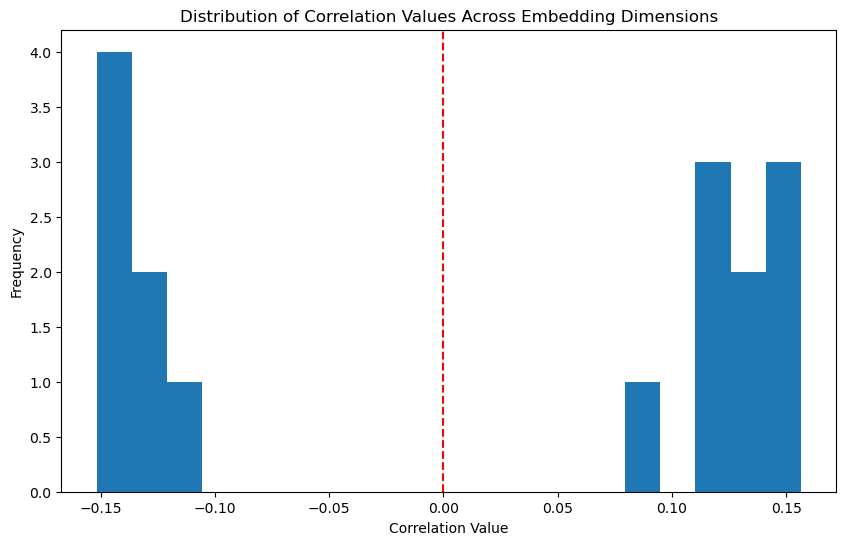


Average Spearman Correlation: 0.0137


([(9, 0.156447360799592, 0.00097935867711683),
  (6, 0.15359096789424254, 0.0012144092873687391),
  (0, -0.15171049174200654, 0.001396405625529827),
  (12, -0.15081558657312996, 0.0014915381547707532),
  (10, 0.1498081886344321, 0.0016057262226797857),
  (15, -0.14694410032816196, 0.00197558169529632),
  (1, -0.14099758913600544, 0.0030034649305730778),
  (4, 0.14060756729375248, 0.0030854678531521498),
  (14, -0.13320151344775877, 0.0050820282285615635),
  (5, -0.1305394643947497, 0.006045474505909613),
  (8, 0.12968975221673415, 0.006385846308097745),
  (13, 0.1236842613382912, 0.009322705844860394),
  (11, 0.12317524554648805, 0.009619770894974528),
  (7, 0.1226877768772626, 0.0099121143056144),
  (2, -0.11996822219191951, 0.011692400552063045),
  (3, 0.0936668809254635, 0.04932803705155351)],
 0.01369881460703292)

In [249]:
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt

def check_embedding_correlation(attentive_embeddings, stock_returns_map):

    embedding_means = []
    return_ratios = []

    for company_id, embeddings in attentive_embeddings.items():
        if company_id in stock_returns_map:
          
            embedding_mean = embeddings.mean(axis=0)
            embedding_means.append(embedding_mean)
            
          
            return_ratios.append(stock_returns_map[company_id][0])  


    embedding_means = np.array(embedding_means)
    return_ratios = np.array(return_ratios)
    
    print(f"Embedding shape: {embedding_means.shape}, Return ratios shape: {return_ratios.shape}")
    

    dim_correlations = []
    for i in range(embedding_means.shape[1]):
        corr, p_value = spearmanr(embedding_means[:, i], return_ratios)
        dim_correlations.append((i, corr, p_value))

    dim_correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    

    print("\nTop 5 correlated embedding dimensions:")
    for i, corr, p_value in dim_correlations[:5]:
        print(f"Dimension {i}: Correlation = {corr:.4f}, p-value = {p_value:.4f}")

    plt.figure(figsize=(10, 6))
    corrs = [c for _, c, _ in dim_correlations]
    plt.hist(corrs, bins=20)
    plt.title("Distribution of Correlation Values Across Embedding Dimensions")
    plt.xlabel("Correlation Value")
    plt.ylabel("Frequency")
    plt.axvline(x=0, color='r', linestyle='--')
    plt.show()
    

    avg_corr = np.mean([c for _, c, _ in dim_correlations])
    print(f"\nAverage Spearman Correlation: {avg_corr:.4f}")
    
    return dim_correlations, avg_corr

check_embedding_correlation(attentive_embeddings, stock_returns_map)

In [250]:
for key in sector_stock_map:
    sector_stock_map[key] = list(set(sector_stock_map[key]))
print(f"Sector stock map: {sector_stock_map}")


Sector stock map: defaultdict(<class 'set'>, {0: [131, 69, 136, 392, 270, 400, 82, 279, 281, 411, 284, 29, 348, 31, 221, 417, 95, 226, 421, 104, 360, 43, 48, 179, 308, 371, 438, 125, 378, 61], 1: [128, 129, 3, 135, 9, 266, 139, 141, 15, 399, 273, 401, 402, 408, 25, 26, 32, 160, 35, 163, 165, 419, 167, 171, 430, 178, 57, 58, 59, 187, 63, 326, 330, 331, 78, 208, 338, 88, 346, 222, 99, 361, 236, 109, 365, 366, 368, 113, 243, 245, 246, 251, 381, 383], 2: [1, 257, 387, 137, 140, 142, 18, 155, 418, 291, 38, 168, 426, 47, 53, 55, 313, 188, 320, 321, 341, 90, 91, 97, 103, 233, 370, 115, 116, 374, 376, 126], 3: [384, 259, 132, 292, 166, 293, 324, 397, 242, 213, 214, 247, 347, 351], 4: [224, 65, 225, 164, 8, 201, 363, 303, 112, 337, 21, 415], 5: [68, 336, 275, 20, 403, 84, 85, 33, 424, 427, 428, 173, 107, 238, 239, 433, 240, 54, 119, 60], 6: [66, 255, 6, 200, 202, 406, 215, 89, 350, 290, 355, 232, 235, 304, 432, 117, 439, 121, 123, 127], 7: [130, 389, 71, 269, 334, 80, 145, 149, 409, 56, 345, 15

In [251]:

weekly_intra_sector_graphs = defaultdict(lambda: defaultdict(list))


for week_idx in range(attentive_embeddings[0].shape[0]):
    print(f"Processing week {week_idx}")
    

    for sector_id, sector_stocks in sector_stock_map.items():
        sector_features = []
        valid_indices = []
        

        for stock_idx in sector_stocks:
            if stock_idx in attentive_embeddings and week_idx < len(attentive_embeddings[stock_idx]):

                tensor_embedding = torch.tensor(attentive_embeddings[stock_idx][week_idx], dtype=torch.float32)
                sector_features.append(tensor_embedding)
                valid_indices.append(stock_idx)

        if len(sector_features) >= 2:
            edge_index = []
            num_nodes = len(valid_indices)

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if i != j:
                        edge_index.append([i, j])

            weekly_intra_sector_graphs[week_idx][sector_id] = Data(
                x=torch.stack(sector_features),
                edge_index=torch.tensor(edge_index).t().contiguous(),
                original_indices=valid_indices,
                sector_id=sector_id  
            )

Processing week 0
Processing week 1
Processing week 2
Processing week 3
Processing week 4
Processing week 5
Processing week 6
Processing week 7
Processing week 8
Processing week 9
Processing week 10
Processing week 11
Processing week 12
Processing week 13
Processing week 14
Processing week 15
Processing week 16
Processing week 17
Processing week 18
Processing week 19
Processing week 20
Processing week 21
Processing week 22
Processing week 23
Processing week 24
Processing week 25
Processing week 26
Processing week 27
Processing week 28
Processing week 29
Processing week 30
Processing week 31
Processing week 32
Processing week 33
Processing week 34
Processing week 35
Processing week 36
Processing week 37
Processing week 38
Processing week 39
Processing week 40
Processing week 41
Processing week 42
Processing week 43
Processing week 44
Processing week 45
Processing week 46
Processing week 47
Processing week 48
Processing week 49
Processing week 50
Processing week 51
Processing week 52
Pro

In [252]:
print(len(weekly_intra_sector_graphs))
print(len(weekly_intra_sector_graphs[0]))
print(weekly_intra_sector_graphs[0].keys())

631
19
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])


In [253]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class IntraSectorGAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model_registry = {}
        self.out_dim = HIDDEN_SIZE  
    
    def forward(self, data):

        x, edge_index = data.x, data.edge_index

        if x.dim() != 2:
            x = x.reshape(-1, x.size(-1))

        in_channels = x.size(1)
        
        if in_channels not in self.model_registry:
            print(f"Creating new GATConv model for input dimension {in_channels}")
            conv = GATConv(
                in_channels=in_channels,
                out_channels=self.out_dim // 4,
                heads=4,
                concat=True,
                negative_slope=0.2,
                dropout=0.1
            ).to(x.device)
            self.model_registry[in_channels] = conv

        conv = self.model_registry[in_channels]
        x = conv(x, edge_index)
        
        return x


In [254]:
model = IntraSectorGAT().to(device)
sector_embeddings = []

model.eval()
with torch.no_grad():
    for week_idx in weekly_intra_sector_graphs:
        for sector_id, graph in weekly_intra_sector_graphs[week_idx].items():

            graph = graph.to(device)
            

            print(f"Graph x shape: {graph.x.shape}, edge_index shape: {graph.edge_index.shape}")
            

            out = model(graph)
            print(f"Output shape: {out.shape}")
            sector_embeddings.append({
                'embeddings': out.cpu(),
                'original_indices': graph.original_indices,
                'sector_id': graph.sector_id,
                'week_idx': week_idx
            })

Graph x shape: torch.Size([30, 16]), edge_index shape: torch.Size([2, 870])
Creating new GATConv model for input dimension 16
Output shape: torch.Size([30, 16])
Graph x shape: torch.Size([54, 16]), edge_index shape: torch.Size([2, 2862])
Output shape: torch.Size([54, 16])
Graph x shape: torch.Size([32, 16]), edge_index shape: torch.Size([2, 992])
Output shape: torch.Size([32, 16])
Graph x shape: torch.Size([14, 16]), edge_index shape: torch.Size([2, 182])
Output shape: torch.Size([14, 16])
Graph x shape: torch.Size([12, 16]), edge_index shape: torch.Size([2, 132])
Output shape: torch.Size([12, 16])
Graph x shape: torch.Size([20, 16]), edge_index shape: torch.Size([2, 380])
Output shape: torch.Size([20, 16])
Graph x shape: torch.Size([20, 16]), edge_index shape: torch.Size([2, 380])
Output shape: torch.Size([20, 16])
Graph x shape: torch.Size([26, 16]), edge_index shape: torch.Size([2, 650])
Output shape: torch.Size([26, 16])
Graph x shape: torch.Size([83, 16]), edge_index shape: torch.

In [255]:
print(len(sector_embeddings))
print(len(sector_embeddings[5]['embeddings']))


11989
20


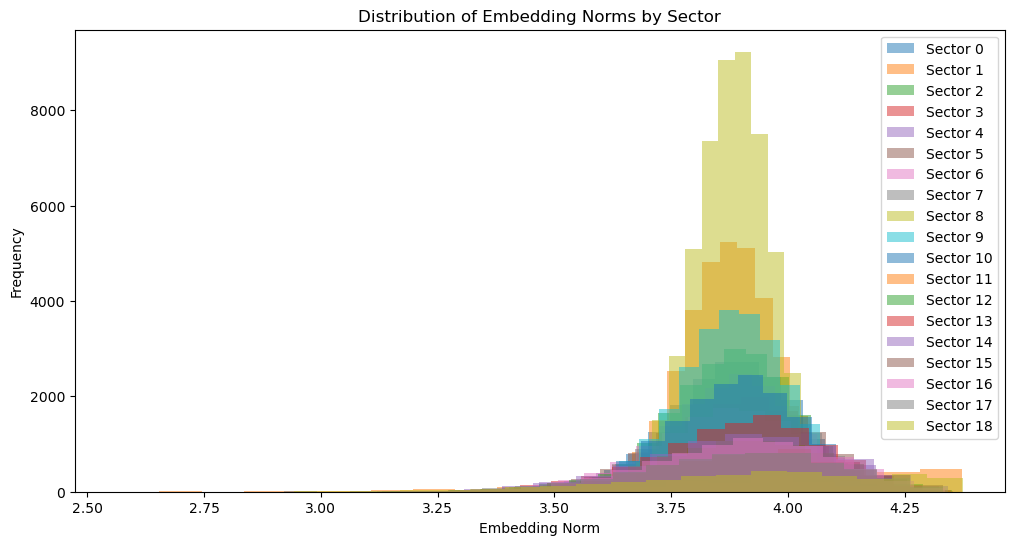

In [256]:
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

def analyze_sector_embeddings(sector_embeddings):

    sector_to_embeddings = {}
    
    for data in sector_embeddings:
        sector_id = data['sector_id']
        if sector_id not in sector_to_embeddings:
            sector_to_embeddings[sector_id] = []
        
        embeddings = data['embeddings'].numpy()
        sector_to_embeddings[sector_id].extend(embeddings)
    

    plt.figure(figsize=(12, 6))
    for sector_id, embeddings in sector_to_embeddings.items():
        norms = [np.linalg.norm(emb) for emb in embeddings]
        plt.hist(norms, alpha=0.5, label=f"Sector {sector_id}", bins=20)
    
    plt.title("Distribution of Embedding Norms by Sector")
    plt.xlabel("Embedding Norm")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    return sector_to_embeddings

sector_to_embeddings = analyze_sector_embeddings(sector_embeddings)

In [257]:


class LongTermTransformerLearner(nn.Module):
    def __init__(self, input_size, hidden_size, lookback_weeks=4, num_layers=2, nhead=4):
        super().__init__()
        self.lookback = lookback_weeks
        self.transformer = TransformerSequentialLearner(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nhead=nhead
        )
        
    def forward(self, sequential_embeddings):

        seq_window = torch.stack(sequential_embeddings[-self.lookback:], dim=1)

        context, _ = self.transformer(seq_window)
        return context


In [258]:

weekly_long_term_embeddings = defaultdict(lambda: defaultdict(dict))
SEQ_LENGTH = 4 

long_term_g = LongTermTransformerLearner(
    input_size=sector_embeddings[0]['embeddings'].shape[1],
    hidden_size=HIDDEN_SIZE,
    lookback_weeks=SEQ_LENGTH
).to(device)

long_term_a = LongTermTransformerLearner(
    input_size=attentive_embeddings[0].shape[1],
    hidden_size=HIDDEN_SIZE,
    lookback_weeks=SEQ_LENGTH
).to(device)

with torch.no_grad():

    company_sector_embeddings = defaultdict(lambda: defaultdict(list))
    
    for sector_data in sector_embeddings:
        week_idx = sector_data['week_idx']
        original_indices = sector_data['original_indices']
        embeddings = sector_data['embeddings']
        

        for i, company_idx in enumerate(original_indices):
            company_sector_embeddings[company_idx][week_idx] = embeddings[i]

    max_week = max([max(weekly_data.keys()) for weekly_data in company_sector_embeddings.values()])
    

    for current_week in range(SEQ_LENGTH, max_week + 1):
        print(f"Processing long-term embeddings for week {current_week}")
        

        for company_idx, weekly_data in company_sector_embeddings.items():

            if current_week not in weekly_data:
                continue

            history_weeks = [w for w in range(current_week - SEQ_LENGTH, current_week)]
            if not all(w in weekly_data for w in history_weeks):
                continue
                
            
            graph_window = []
            for w in history_weeks:
                if w in weekly_data:
                    graph_emb = torch.tensor(weekly_data[w]).unsqueeze(0).to(device)
                    graph_window.append(graph_emb)

            if company_idx in attentive_embeddings:
                attentive_seqs = attentive_embeddings[company_idx]
                
                if len(attentive_seqs) >= SEQ_LENGTH:
     
                    attentive_window = []
                    for i in range(SEQ_LENGTH):
                       
                        seq_idx = len(attentive_seqs) - SEQ_LENGTH + i
                        if seq_idx >= 0 and seq_idx < len(attentive_seqs):
                            att_emb = torch.tensor(attentive_seqs[seq_idx], dtype=torch.float32).unsqueeze(0).to(device)
                            attentive_window.append(att_emb)
                    

                    if len(graph_window) == SEQ_LENGTH and len(attentive_window) == SEQ_LENGTH:

                        tau_G = long_term_g(graph_window)
                        tau_A = long_term_a(attentive_window)
                        
                       
                        weekly_long_term_embeddings[current_week][company_idx] = {
                            'graph': tau_G.cpu().numpy(),
                            'attentive': tau_A.cpu().numpy()
                        }


    long_term_graph_embeddings = {}
    long_term_attentive_embeddings = {}
    

    for week in sorted(weekly_long_term_embeddings.keys(), reverse=True):
        for company_idx, embeddings in weekly_long_term_embeddings[week].items():
            if company_idx not in long_term_graph_embeddings:
                long_term_graph_embeddings[company_idx] = embeddings['graph']
                long_term_attentive_embeddings[company_idx] = embeddings['attentive']

print(f"Generated weekly long-term embeddings for {len(weekly_long_term_embeddings)} weeks")
print(f"Generated company long-term embeddings for {len(long_term_graph_embeddings)} companies")


print("\nExample of weekly embedding structure:")
sample_week = list(weekly_long_term_embeddings.keys())[0]
sample_company = list(weekly_long_term_embeddings[sample_week].keys())[0]
print(f"Week {sample_week}, Company {sample_company}:")
print(f"Graph embedding shape: {weekly_long_term_embeddings[sample_week][sample_company]['graph'].shape}")
print(f"Attentive embedding shape: {weekly_long_term_embeddings[sample_week][sample_company]['attentive'].shape}")

Processing long-term embeddings for week 4


/var/folders/gn/mtbdxhjn1697bp_qhyd6y0cr0000gn/T/ipykernel_32968/366402632.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  graph_emb = torch.tensor(weekly_data[w]).unsqueeze(0).to(device)


Processing long-term embeddings for week 5
Processing long-term embeddings for week 6
Processing long-term embeddings for week 7
Processing long-term embeddings for week 8
Processing long-term embeddings for week 9
Processing long-term embeddings for week 10
Processing long-term embeddings for week 11
Processing long-term embeddings for week 12
Processing long-term embeddings for week 13
Processing long-term embeddings for week 14
Processing long-term embeddings for week 15
Processing long-term embeddings for week 16
Processing long-term embeddings for week 17
Processing long-term embeddings for week 18
Processing long-term embeddings for week 19
Processing long-term embeddings for week 20
Processing long-term embeddings for week 21
Processing long-term embeddings for week 22
Processing long-term embeddings for week 23
Processing long-term embeddings for week 24
Processing long-term embeddings for week 25
Processing long-term embeddings for week 26
Processing long-term embeddings for w

Average similarity: 0.0863

Most different companies (graph vs attentive):
Company ID 167: Similarity = 0.0011
Company ID 163: Similarity = 0.0041
Company ID 276: Similarity = 0.0069
Company ID 91: Similarity = 0.0125
Company ID 57: Similarity = 0.0129

Most similar companies (graph vs attentive):
Company ID 98: Similarity = 0.1624
Company ID 429: Similarity = 0.1644
Company ID 66: Similarity = 0.1654
Company ID 432: Similarity = 0.1742
Company ID 208: Similarity = 0.1763


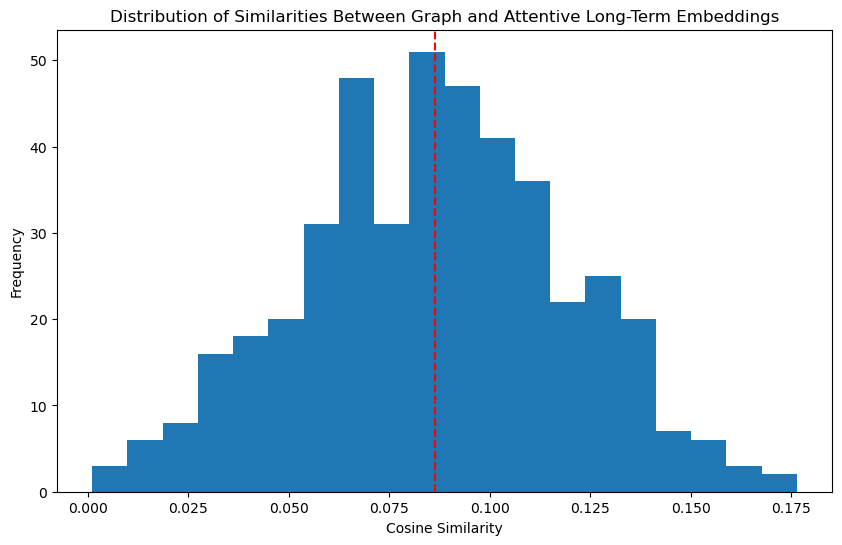

In [259]:
def compare_embeddings(long_term_graph_embeddings, long_term_attentive_embeddings):
    """Compare the graph-based and attentive-based long-term embeddings"""
    
    # Calculate similarities between graph and attentive embeddings
    similarities = []
    companies = []
    
    for company_id in long_term_graph_embeddings.keys():
        if company_id in long_term_attentive_embeddings:
            graph_emb = long_term_graph_embeddings[company_id]
            att_emb = long_term_attentive_embeddings[company_id]
            
            # Calculate cosine similarity
            from scipy.spatial.distance import cosine
            sim = 1 - cosine(graph_emb.flatten(), att_emb.flatten())
            similarities.append(sim)
            companies.append(company_id)
    
    plt.figure(figsize=(10, 6))
    plt.hist(similarities, bins=20)
    plt.axvline(x=np.mean(similarities), color='r', linestyle='--')
    plt.title("Distribution of Similarities Between Graph and Attentive Long-Term Embeddings")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    print(f"Average similarity: {np.mean(similarities):.4f}")
    
    # Find most similar and most different companies
    sorted_sims = sorted(zip(companies, similarities), key=lambda x: x[1])
    print("\nMost different companies (graph vs attentive):")
    for company_id, sim in sorted_sims[:5]:
        print(f"Company ID {company_id}: Similarity = {sim:.4f}")
    
    print("\nMost similar companies (graph vs attentive):")
    for company_id, sim in sorted_sims[-5:]:
        print(f"Company ID {company_id}: Similarity = {sim:.4f}")
        
    plt.show()

compare_embeddings(long_term_graph_embeddings, long_term_attentive_embeddings)

In [260]:
import math
def enhanced_sector_pooling(graph_data):
    x = graph_data.x
    sector_id = graph_data.sector_id
    

    torch.manual_seed(sector_id * 100)

    if sector_id % 4 == 0:  
 
        combined_pool = 0.5 * torch.max(x, dim=0)[0] + 0.2 * torch.mean(x, dim=0) + 0.3 * torch.std(x, dim=0)
    elif sector_id % 4 == 1:

        combined_pool = 0.2 * torch.max(x, dim=0)[0] + 0.5 * torch.min(x, dim=0)[0] + 0.3 * torch.quantile(x, 0.25, dim=0)
    elif sector_id % 4 == 2: 

        combined_pool = 0.3 * torch.mean(x, dim=0) + 0.7 * torch.std(x, dim=0)
    else:  

        combined_pool = 0.4 * torch.quantile(x, 0.5, dim=0) + 0.3 * torch.quantile(x, 0.75, dim=0) + 0.3 * torch.quantile(x, 0.25, dim=0)

    sector_factor = ((sector_id % 7) + 1) / 4.0  
    if sector_id % 3 == 0:

        combined_pool = torch.tanh(sector_factor * combined_pool)
    elif sector_id % 3 == 1:

        combined_pool = F.leaky_relu(sector_factor * combined_pool, negative_slope=0.1)
    else:

        combined_pool = torch.clamp(torch.exp(sector_factor * combined_pool * 0.1) - 1, -5, 5)

    dim = combined_pool.size(0)

    noise_scaling = 0.5 + (sector_id % 10) * 0.1 
    orthogonal_noise = torch.zeros_like(combined_pool)

    for i in range(dim):
        phase = (sector_id * 0.1) + (i * 0.3 * (1 + sector_id % 5))
        orthogonal_noise[i] = torch.sin(torch.tensor(phase * math.pi))

    noise = (torch.randn_like(combined_pool) * 0.4) + (orthogonal_noise * noise_scaling)
    combined_pool = combined_pool + noise

    if sector_id % 2 == 0:

        norm = torch.norm(combined_pool)
        if norm > 0:
            combined_pool = combined_pool / norm
    
    return combined_pool

In [261]:

weekly_sector_pooled_embeddings = defaultdict(dict)
embedding_dim = sector_embeddings[0]['embeddings'].shape[1]

print("Performing enhanced pooling for each sector and week...")


for week_idx in sorted(weekly_intra_sector_graphs.keys()):

    for sector_id in weekly_intra_sector_graphs[week_idx]:
        graph = weekly_intra_sector_graphs[week_idx][sector_id]
        
  
        pooled_embedding = enhanced_sector_pooling(graph)
        
        weekly_sector_pooled_embeddings[week_idx][sector_id] = pooled_embedding

total_pooled_embeddings = sum(len(sectors) for sectors in weekly_sector_pooled_embeddings.values())
print(f"Created pooled embeddings for {len(weekly_sector_pooled_embeddings)} weeks and {total_pooled_embeddings} sector-week combinations")

Performing enhanced pooling for each sector and week...
Created pooled embeddings for 631 weeks and 11989 sector-week combinations



Checking embedding diversity for 19 sectors in week 0
Similarity stats - Min: -0.8778, Max: 0.7414, Avg: 0.0457

Most similar sector pairs:
Sectors 1 and 13: 0.7414
Sectors 3 and 12: 0.7199
Sectors 12 and 13: 0.7035

Most different sector pairs:
Sectors 2 and 12: -0.7766
Sectors 7 and 17: -0.8461
Sectors 8 and 18: -0.8778


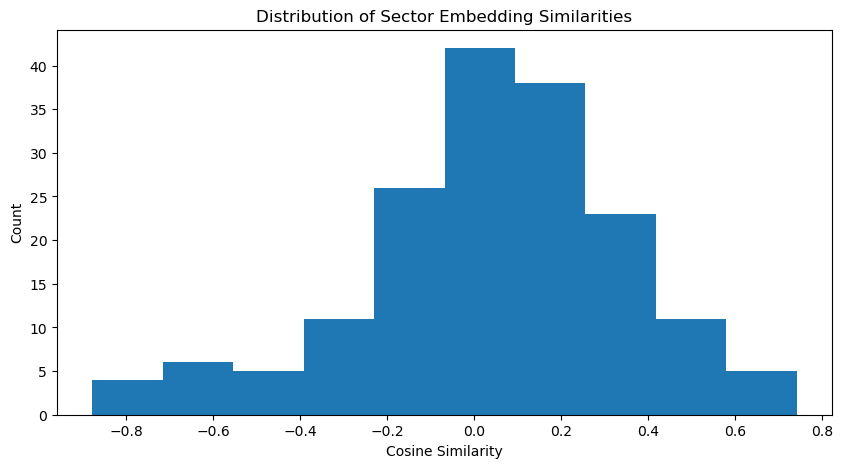

In [262]:
from scipy.spatial.distance import cosine
def check_pooling_diversity(weekly_sector_pooled_embeddings, week_idx=0):
 
    if week_idx not in weekly_sector_pooled_embeddings:
        print(f"Week {week_idx} not found")
        return
        
    sectors_this_week = weekly_sector_pooled_embeddings[week_idx]
    sector_ids = list(sectors_this_week.keys())
    
    if len(sector_ids) < 2:
        print("Not enough sectors to compare")
        return
        
    print(f"\nChecking embedding diversity for {len(sector_ids)} sectors in week {week_idx}")
    
    
    similarities = []
    for i in range(len(sector_ids)):
        for j in range(i+1, len(sector_ids)):
           
            s1 = sectors_this_week[sector_ids[i]].cpu().numpy()
            s2 = sectors_this_week[sector_ids[j]].cpu().numpy()
            sim = 1 - cosine(s1, s2)  
            similarities.append((sector_ids[i], sector_ids[j], sim))

    similarities.sort(key=lambda x: x[2], reverse=True)
 
    sim_values = [s[2] for s in similarities]
    print(f"Similarity stats - Min: {min(sim_values):.4f}, Max: {max(sim_values):.4f}, Avg: {np.mean(sim_values):.4f}")

    print("\nMost similar sector pairs:")
    for i, j, sim in similarities[:3]:
        print(f"Sectors {i} and {j}: {sim:.4f}")

    print("\nMost different sector pairs:")
    for i, j, sim in similarities[-3:]:
        print(f"Sectors {i} and {j}: {sim:.4f}")
    
    # Visualize distribution
    plt.figure(figsize=(10, 5))
    plt.hist(sim_values, bins=10)
    plt.title("Distribution of Sector Embedding Similarities")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Count")
    plt.show()


first_week = min(weekly_sector_pooled_embeddings.keys())
check_pooling_diversity(weekly_sector_pooled_embeddings, first_week)

In [263]:
def create_sector_embeddings(sector_stock_map, embedding_dim=16, hidden_channels=32):
    """
    Create sector embeddings directly using an embedding layer instead of GAT
    
    Args:
        sector_stock_map: Mapping from sector IDs to lists of stocks
        embedding_dim: Dimension of the output embeddings
        hidden_channels: Internal dimension for transformations
    
    Returns:
        A dictionary mapping week indices to dictionaries of sector embeddings
    """
    print("Creating sector embeddings using direct embedding approach...")
    
    # Get number of sectors and create the embedding layer
    num_sectors = len(sector_stock_map)
    sector_embedding = nn.Embedding(num_sectors + 10, embedding_dim).to(device)  # +10 for safety
    
    # Add a projection layer to get the desired output dimension
    projection = nn.Sequential(
        nn.Linear(embedding_dim, hidden_channels),
        nn.LayerNorm(hidden_channels),
        nn.ReLU(),
        nn.Linear(hidden_channels, embedding_dim)
    ).to(device)
    
    # Create a consistent mapping from weeks to sector embeddings
    weekly_inter_sector_embeddings = defaultdict(dict)
    
    # Use the same set of weeks as in the pooled embeddings
    for week_idx in sorted(weekly_sector_pooled_embeddings.keys()):
        sectors_this_week = weekly_sector_pooled_embeddings[week_idx]
        
        # Process each sector
        for sector_id in sectors_this_week.keys():
            # Use direct sector ID for embedding lookup
            sector_tensor = torch.tensor([sector_id], device=device)
            
            # Get the sector embedding and apply projection
            with torch.no_grad():
                embedding = sector_embedding(sector_tensor)
                embedding = projection(embedding)
                
            # Store the sector embedding for this week
            weekly_inter_sector_embeddings[week_idx][sector_id] = embedding.squeeze(0).cpu()
    
    print(f"Created sector embeddings for {len(weekly_inter_sector_embeddings)} weeks")
    return weekly_inter_sector_embeddings

Creating sector embeddings using direct embedding approach...
Created sector embeddings for 631 weeks

Checking embedding diversity for 19 sectors in week 0
Similarity stats - Min: -0.1711, Max: 0.8847, Avg: 0.3812

Most similar sector pairs:
Sectors 13 and 14: 0.8847
Sectors 4 and 8: 0.8682
Sectors 14 and 16: 0.8462

Most different sector pairs:
Sectors 8 and 15: -0.0932
Sectors 12 and 17: -0.1256
Sectors 6 and 9: -0.1711


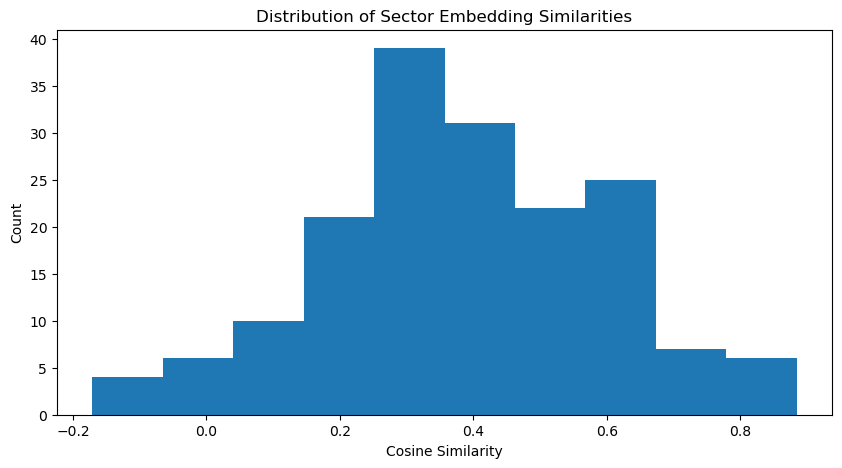

In [264]:
# Replace the existing GAT-based approach with direct embeddings
weekly_inter_sector_embeddings = create_sector_embeddings(
    sector_stock_map,
    embedding_dim=HIDDEN_SIZE,
    hidden_channels=HIDDEN_SIZE * 2
)

# Check the diversity of the embeddings
first_week = min(weekly_inter_sector_embeddings.keys())
check_pooling_diversity(weekly_inter_sector_embeddings, first_week)




Similarity statistics (excluding diagonal):
  Min: -0.1711
  Max: 0.8848
  Mean: 0.3812
  Std Dev: 0.2126
  Number of unique values: 169


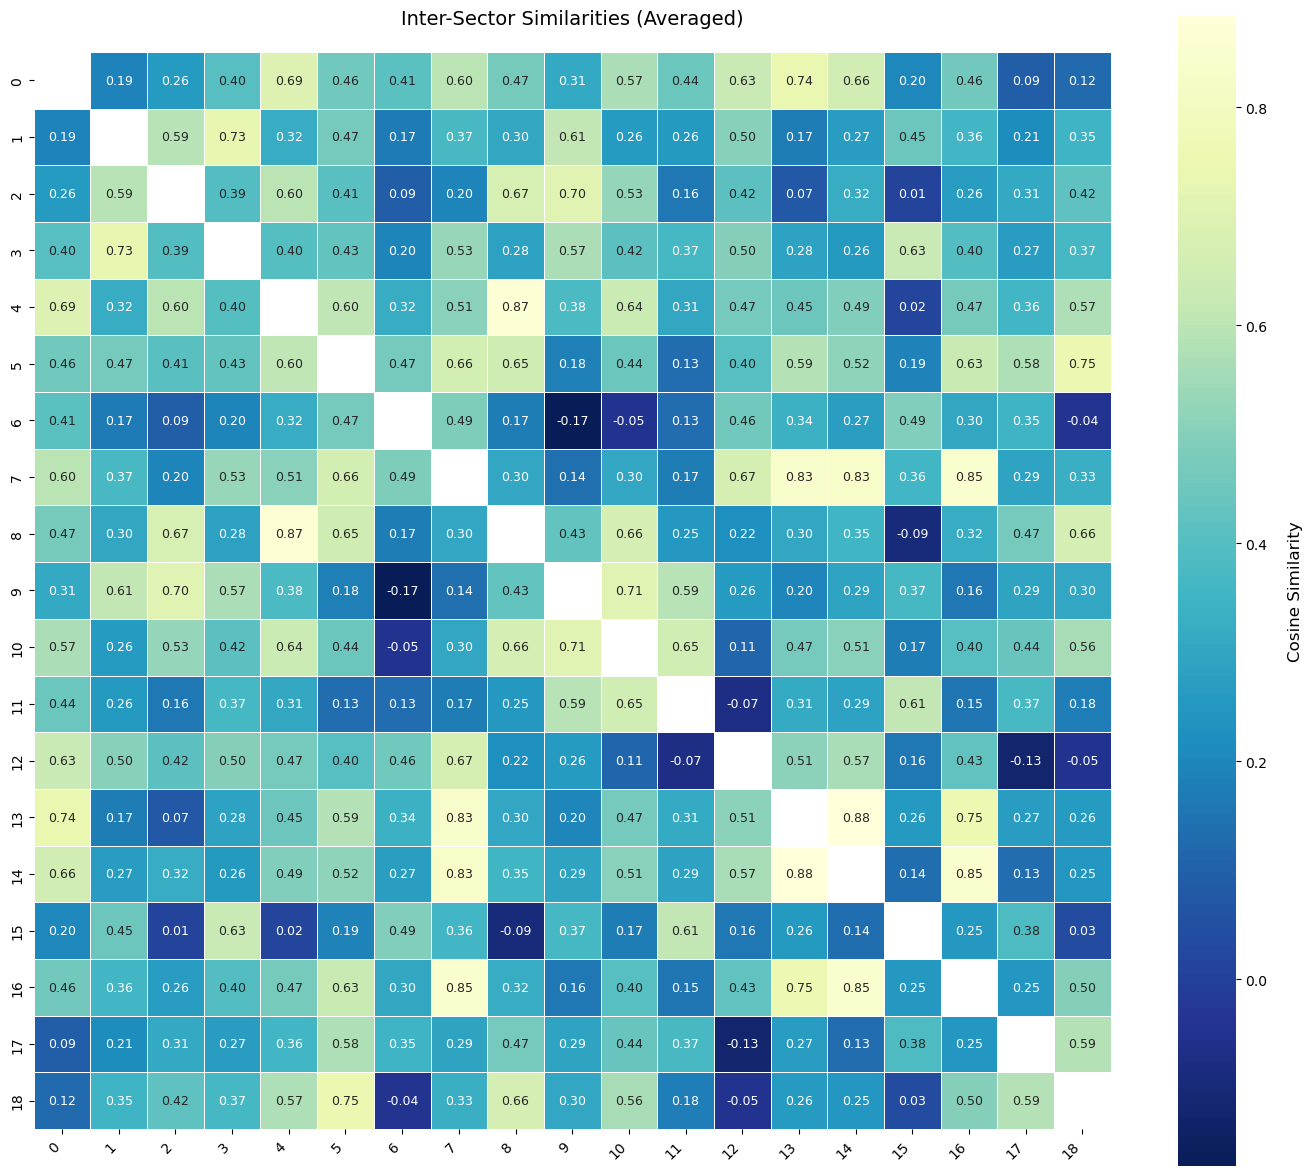


Top 5 Most Similar Sector Pairs:
Sector 13 - Sector 14: 0.8848
Sector 4 - Sector 8: 0.8682
Sector 14 - Sector 16: 0.8462
Sector 7 - Sector 16: 0.8456
Sector 7 - Sector 13: 0.8336

Top 5 Least Similar Sector Pairs:
Sector 6 - Sector 10: -0.0501
Sector 11 - Sector 12: -0.0693
Sector 8 - Sector 15: -0.0932
Sector 12 - Sector 17: -0.1256
Sector 6 - Sector 9: -0.1711


In [265]:
def visualize_sector_similarities_improved(weekly_inter_sector_embeddings, week_idx=None):
    """
    Create a heatmap showing similarities between sectors with improved visualization 
    and diagnostics to help identify issues
    """
    import seaborn as sns
    from scipy.spatial.distance import cosine
    import matplotlib.colors as mcolors
    
    # Get sector embeddings
    if week_idx is None:
        sector_embeddings = {}
        for week, sectors in weekly_inter_sector_embeddings.items():
            for sector_id, embedding in sectors.items():
                if sector_id not in sector_embeddings:
                    sector_embeddings[sector_id] = []
                sector_embeddings[sector_id].append(embedding.numpy())
                
        # Average embeddings across weeks
        for sector_id in sector_embeddings:
            sector_embeddings[sector_id] = np.mean(np.stack(sector_embeddings[sector_id]), axis=0)
    else:
        if week_idx not in weekly_inter_sector_embeddings:
            print(f"Week {week_idx} not found in the data")
            return
        
        sector_embeddings = {sector_id: embedding.numpy() for sector_id, embedding 
                           in weekly_inter_sector_embeddings[week_idx].items()}
    
    # Get all sector IDs
    sector_ids = sorted(sector_embeddings.keys())
    num_sectors = len(sector_ids)
    
    # Calculate cosine similarity matrix
    similarity_matrix = np.zeros((num_sectors, num_sectors))
    
    for i, sector1 in enumerate(sector_ids):
        for j, sector2 in enumerate(sector_ids):
            # Check if embeddings contain NaNs or infinities
            if np.any(np.isnan(sector_embeddings[sector1])) or np.any(np.isnan(sector_embeddings[sector2])) or \
               np.any(np.isinf(sector_embeddings[sector1])) or np.any(np.isinf(sector_embeddings[sector2])):
                similarity = np.nan
            else:
                # Add epsilon to avoid zero division for zero vectors
                similarity = 1 - cosine(sector_embeddings[sector1] + 1e-10, sector_embeddings[sector2] + 1e-10)
            similarity_matrix[i, j] = similarity
    
    # Print statistics about similarity values (excluding diagonal)
    np.fill_diagonal(similarity_matrix, np.nan)  # Mask diagonal for statistics
    flat_sims = similarity_matrix[~np.isnan(similarity_matrix)]
    
    print(f"Similarity statistics (excluding diagonal):")
    print(f"  Min: {np.min(flat_sims):.4f}")
    print(f"  Max: {np.max(flat_sims):.4f}")
    print(f"  Mean: {np.mean(flat_sims):.4f}")
    print(f"  Std Dev: {np.std(flat_sims):.4f}")
    print(f"  Number of unique values: {len(np.unique(np.round(flat_sims, 4)))}")
    
    # Calculate vmin, vmax, and center for the heatmap
    min_sim = np.min(flat_sims)
    max_sim = np.max(flat_sims)
    center = (min_sim + max_sim) / 2  # Center point for the colormap
    
    # Restore diagonal for visualization
    np.fill_diagonal(similarity_matrix, 1.0)
    
    # Create heatmap with adaptive color range
    plt.figure(figsize=(14, 12))  # Increased figure size for clarity

    # Create a custom colormap with blue -> green -> yellow progression
    custom_cmap = sns.color_palette("YlGnBu_r", as_cmap=True)  # Yellow-Green-Blue reversed

    # Use a mask for the diagonal
    mask = np.zeros_like(similarity_matrix, dtype=bool)
    np.fill_diagonal(mask, True)

    # Create heatmap with improved visualization
    sns.heatmap(
        similarity_matrix, 
        mask=mask,
        annot=True, 
        cmap=custom_cmap,  # Custom blue-green-yellow colormap
        vmin=min_sim,
        vmax=max_sim,
        center=center,
        xticklabels=sector_ids, 
        yticklabels=sector_ids,
        linewidths=0.7,  # Slightly thicker lines for better visibility
        annot_kws={"size": 9},  # Adjust annotation text size
        fmt=".2f",  # Show 2 decimal places
        square=True  # Ensure cells are square
    )
    # Improve title and overall appearance
    title = f"Inter-Sector Similarities - Week {week_idx}" if week_idx else "Inter-Sector Similarities (Averaged)"
    plt.title(title, fontsize=14, pad=20)

    # Add grid for better readability
    plt.grid(False)

    # Add colorbar label
    cbar = plt.gca().collections[0].colorbar
    cbar.set_label("Cosine Similarity", fontsize=12, labelpad=15)

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()
    # Find most/least similar pairs (excluding self-similarity)
    most_similar = []
    for i in range(num_sectors):
        for j in range(i+1, num_sectors):
            most_similar.append((sector_ids[i], sector_ids[j], similarity_matrix[i, j]))
    
    most_similar.sort(key=lambda x: x[2], reverse=True)
    
    print("\nTop 5 Most Similar Sector Pairs:")
    for sector1, sector2, sim in most_similar[:5]:
        print(f"Sector {sector1} - Sector {sector2}: {sim:.4f}")
    
    print("\nTop 5 Least Similar Sector Pairs:")
    for sector1, sector2, sim in most_similar[-5:]:
        print(f"Sector {sector1} - Sector {sector2}: {sim:.4f}")

visualize_sector_similarities_improved(weekly_inter_sector_embeddings, week_idx=None)


In [266]:
class EmbeddingFusion(nn.Module):
    def __init__(self, attentive_dim, graph_dim, sector_dim, output_dim=64):
        super().__init__()
        self.input_dim = attentive_dim + graph_dim + sector_dim
        self.fusion_layer = nn.Linear(self.input_dim, output_dim)
        
    def forward(self, attentive_emb, graph_emb, sector_emb):
        """
        Fuses three embedding types into a single representation
        """
        # Normalize dimensions
        if graph_emb.dim() > 2:
            graph_emb = graph_emb.squeeze(1)
        if attentive_emb.dim() > 2:
            attentive_emb = attentive_emb.squeeze(1)
        
        # Three-way concatenation
        concatenated = torch.cat([graph_emb, attentive_emb, sector_emb], dim=-1)
        
        # Apply fusion transformation with ReLU
        fused = F.relu(self.fusion_layer(concatenated))
        
        return fused

In [267]:
class FinGAT(nn.Module):
    def __init__(self, attentive_dim=16, graph_dim=16, sector_dim=16, hidden_dim=64):
        super().__init__()
        
        # Embedding fusion layer - now with only three embeddings
        self.fusion = EmbeddingFusion(
            attentive_dim=attentive_dim,
            graph_dim=graph_dim,
            sector_dim=sector_dim,
            output_dim=hidden_dim
        )
        
        # Task-specific layers
        self.return_ratio_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )

        self.movement_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )
        
    def forward(self, attentive_emb, graph_emb, sector_emb):
        """
        Forward pass with simplified three-way embedding fusion
        """
        # Three-way fusion of embeddings
        fused_embedding = self.fusion(attentive_emb, graph_emb, sector_emb)
        
        # Task-specific predictions
        return_ratio_pred = self.return_ratio_layer(fused_embedding).squeeze(-1)
        movement_pred = torch.sigmoid(self.movement_layer(fused_embedding)).squeeze(-1)
        
        # Make sure all outputs have proper dimensions
        return_ratio_pred = return_ratio_pred.view(-1)
        movement_pred = movement_pred.view(-1)
        
        return return_ratio_pred, movement_pred

In [268]:
class MultiTaskLoss:
    def __init__(self, alpha=0.5):
        """
        Multi-task loss without auxiliary return prediction
        Args:
            alpha: Weight between ranking loss and movement loss
        """
        self.alpha = alpha
        self.bce_loss = nn.BCELoss()
        
    def pairwise_ranking_loss(self, predictions, targets):
        # Same as before
        n = predictions.size(0)
        pairs_i, pairs_j = torch.triu_indices(n, n, offset=1)
        
        pred_diff = predictions[pairs_i] - predictions[pairs_j]
        target_diff = targets[pairs_i] - targets[pairs_j]
        
        target_sign = torch.sign(target_diff)
        
        margin = 0.1
        loss = F.relu(-target_sign * pred_diff + margin)
        
        return loss.mean()
    
    def __call__(self, return_preds, return_targets, move_preds, move_targets):
        """
        Calculate combined multi-task loss
        """
        # Ensure consistent shapes
        return_preds = return_preds.view(-1)
        return_targets = return_targets.view(-1)
        move_preds = move_preds.view(-1)
        move_targets = move_targets.view(-1)
        
        # Calculate main losses
        ranking_loss = self.pairwise_ranking_loss(return_preds, return_targets)
        movement_loss = self.bce_loss(move_preds, move_targets)
        
        # Combined loss
        combined_loss = self.alpha * ranking_loss + (1 - self.alpha) * movement_loss
        
        return combined_loss, ranking_loss, movement_loss

In [269]:
def prepare_weekly_data(week_idx, weekly_long_term_embeddings, weekly_inter_sector_embeddings, stock_sector_map):
    """
    Prepares training data for a specific week by aligning embeddings and labels
    Args:
        week_idx: The week index to prepare data for
        weekly_long_term_embeddings: Dictionary of long-term embeddings (by week, company)
        weekly_inter_sector_embeddings: Dictionary of sector embeddings (by week, sector)
        stock_sector_map: Mapping from stocks to their sectors
    Returns:
        Dictionary of aligned data ready for training
    """
    # Skip if this week doesn't have both types of embeddings
    if (week_idx not in weekly_long_term_embeddings or 
        week_idx not in weekly_inter_sector_embeddings):
        print(f'skipping week:{week_idx}')
        return None
    
    training_data = {
        'attentive_embs': [],
        'graph_embs': [],
        'sector_embs': [],
        'companies': [],
        'returns': [],
        'movements': []
    }
    
    # For each company that has data in this week
    for company_idx, company_data in weekly_long_term_embeddings[week_idx].items():
        # Get the stock's sector (assuming each stock belongs to only one sector)
        if company_idx not in stock_sector_map or len(stock_sector_map[company_idx]) == 0:
            continue
            
        sector_id = list(stock_sector_map[company_idx])[0]  # Take the first sector if multiple
        
        # Check if we have the sector embedding for this week
        if sector_id not in weekly_inter_sector_embeddings[week_idx]:
            continue
            
        # Extract embeddings
        attentive_emb = torch.tensor(company_data['attentive'], dtype=torch.float32)
        graph_emb = torch.tensor(company_data['graph'], dtype=torch.float32)
        sector_emb = weekly_inter_sector_embeddings[week_idx][sector_id]
        
        # Get return and movement labels for this company at this week
        if company_idx not in stock_returns_map:
            continue
            
        # Align with the correct week's return data
        # This is a simplification - you'll need to properly align with your data
        target_week = week_idx  # Use current week's return (or week_idx + 1 for next week)
        
        if 0 <= target_week < len(stock_returns_map[company_idx]):
            return_ratio = stock_returns_map[company_idx][target_week]
            movement = 1.0 if return_ratio > 0 else 0.0
            
            
            # Add to training data
            training_data['attentive_embs'].append(attentive_emb)
            training_data['graph_embs'].append(graph_emb)
            training_data['sector_embs'].append(sector_emb)
            training_data['companies'].append(company_idx)
            training_data['returns'].append(return_ratio)
            training_data['movements'].append(movement)
    
    # Convert to tensors if we have data
    if training_data['returns']:
        training_data['attentive_embs'] = torch.stack(training_data['attentive_embs'])
        training_data['graph_embs'] = torch.stack(training_data['graph_embs'])
        training_data['sector_embs'] = torch.stack(training_data['sector_embs'])
        training_data['returns'] = torch.tensor(training_data['returns'], dtype=torch.float32)
        training_data['movements'] = torch.tensor(training_data['movements'], dtype=torch.float32)
        return training_data
    else:
        return None

In [270]:
def calculate_rank_based_r2(predictions, targets):
    """
    Calculate R² score based on rankings rather than absolute values.
    
    Args:
        predictions: Predicted return ratios
        targets: Actual return ratios
        
    Returns:
        R² score based on ranking performance
    """
    # Convert tensors to numpy if needed
    if torch.is_tensor(predictions):
        predictions = predictions.detach().cpu().numpy()
    if torch.is_tensor(targets):
        targets = targets.detach().cpu().numpy()
    
    # Convert to rankings (scipy.stats.rankdata sorts in ascending order)
    from scipy import stats
    pred_ranks = stats.rankdata(-predictions)  # Negative to rank in descending order
    true_ranks = stats.rankdata(-targets)      # Higher returns should have lower rank numbers
    
    # Calculate R² using the ranking formula
    mean_true_rank = np.mean(true_ranks)
    ss_tot = np.sum((true_ranks - mean_true_rank) ** 2)
    ss_res = np.sum((true_ranks - pred_ranks) ** 2)
    
    if ss_tot == 0:  # Avoid division by zero
        return 0.0
    
    # R² formula: 1 - (residual sum of squares / total sum of squares)
    return 1 - (ss_res / ss_tot)

In [271]:
def train_fingat(epochs=50, learning_rate=0.001):
    """
    Training loop for the simplified FinGAT model (no return embeddings)
    """
    from sklearn.metrics import r2_score
    
    # Initialize model
    model = FinGAT(
        attentive_dim=HIDDEN_SIZE,
        graph_dim=HIDDEN_SIZE,
        sector_dim=HIDDEN_SIZE,
        hidden_dim=64
    ).to(device)
    
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Fix: Remove beta parameter
    criterion = MultiTaskLoss(alpha=0.5)
    
    # Neural network training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        ranking_losses = 0.0
        movement_losses = 0.0
        batch_count = 0
        
        # For R2 calculation
        all_return_preds = []
        all_return_targets = []
        
        # Process each week's data
        for week_idx in sorted(weekly_long_term_embeddings.keys()):
            week_data = prepare_weekly_data(
                week_idx, 
                weekly_long_term_embeddings, 
                weekly_inter_sector_embeddings,
                stock_sector_map
            )
            
            if week_data and len(week_data['returns']) > 1:
                # Move to device
                attentive_embs = week_data['attentive_embs'].to(device)
                graph_embs = week_data['graph_embs'].to(device)
                sector_embs = week_data['sector_embs'].to(device)
                return_targets = week_data['returns'].to(device)
                movement_targets = week_data['movements'].to(device)
                
                # Forward pass (now only returns two outputs)
                return_preds, movement_preds = model(attentive_embs, graph_embs, sector_embs)
                
                # Compute loss
                loss, ranking_loss, move_loss = criterion(
                    return_preds, return_targets, movement_preds, movement_targets
                )
                
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Record losses
                total_loss += loss.item()
                ranking_losses += ranking_loss.item()
                movement_losses += move_loss.item()
                batch_count += 1
                
                # Collect predictions and targets for R2 calculation
                all_return_preds.extend(return_preds.detach().cpu().numpy())
                all_return_targets.extend(return_targets.detach().cpu().numpy())
        
        # Report progress
        if batch_count > 0:
            r2 = r2_score(all_return_targets, all_return_preds) if len(all_return_preds) > 1 else 0.0
            rank_r2 = calculate_rank_based_r2(np.array(all_return_preds), np.array(all_return_targets))
            
            print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/batch_count:.4f} "
                  f"(Ranking: {ranking_losses/batch_count:.4f}, Movement: {movement_losses/batch_count:.4f}, "
                  f"R²: {r2:.4f}, Rank R²: {rank_r2:.4f})")
    
    return model

In [272]:
def evaluate_fingat(model):
    """
    Evaluate the FinGAT model's performance with additional MRR metrics
    """
    model.eval()
    
    all_return_preds = []
    all_return_targets = []
    all_movement_preds = []
    all_movement_targets = []
    
    # Store predictions by week for MRR calculation
    weekly_predictions = defaultdict(lambda: {'preds': [], 'targets': [], 'companies': []})
    
    with torch.no_grad():
        # Use the last week for evaluation
        eval_weeks = sorted(weekly_long_term_embeddings.keys())[-3:]  # Last 3 weeks for example
        
        for week_idx in eval_weeks:
            week_data = prepare_weekly_data(
                week_idx, 
                weekly_long_term_embeddings, 
                weekly_inter_sector_embeddings,
                stock_sector_map
            )
            
            if week_data and len(week_data['returns']) > 0:
                # Move to device
                attentive_embs = week_data['attentive_embs'].to(device)
                graph_embs = week_data['graph_embs'].to(device)
                sector_embs = week_data['sector_embs'].to(device)
                
                # Get predictions - now correctly unpacking all 3 return values
                return_preds, movement_preds = model(attentive_embs, graph_embs, sector_embs)
                
                # Collect results
                return_preds_np = return_preds.cpu().numpy()
                return_targets_np = week_data['returns'].numpy()
                
                all_return_preds.extend(return_preds_np)
                all_return_targets.extend(return_targets_np)
                all_movement_preds.extend(movement_preds.cpu().numpy())
                all_movement_targets.extend(week_data['movements'].numpy())
                
                # Store by week for MRR calculation
                weekly_predictions[week_idx]['preds'].extend(return_preds_np)
                weekly_predictions[week_idx]['targets'].extend(return_targets_np)
                weekly_predictions[week_idx]['companies'].extend(week_data['companies'])
    

    from scipy.stats import spearmanr
    corr, _ = spearmanr(all_return_preds, all_return_targets)
    

    threshold = 0.5
    binary_preds = [1 if p > threshold else 0 for p in all_movement_preds]
    

    accuracy = sum(p == t for p, t in zip(binary_preds, all_movement_targets)) / len(binary_preds) if binary_preds else 0
    

    mrr_values = []      
    mrr_top5_values = []
    mrr_top10_values = []
    mrr_top20_values = []
    mrr_top30_values = []
    
    for week_idx, week_data in weekly_predictions.items():
        if not week_data['preds']:
            continue

        pred_target_pairs = list(zip(week_data['preds'], week_data['targets'], week_data['companies']))
        

        pred_ranking = sorted(pred_target_pairs, key=lambda x: x[0], reverse=True)

        company_to_pred_rank = {company: i+1 for i, (_, _, company) in enumerate(pred_ranking)}
        
      
        true_ranking = sorted(
            [(target, company) for (_, target, company) in pred_target_pairs],
            key=lambda x: x[0],
            reverse=True
        )
        

        if true_ranking:
            _, best_company = true_ranking[0]
            if best_company in company_to_pred_rank:
                mrr_values.append(1.0 / company_to_pred_rank[best_company])

        top_k_values = [5, 10, 20, 30]
        for k in top_k_values:
            mrr_at_k = []

            for j, (_, company) in enumerate(true_ranking[:k]):
                if company in company_to_pred_rank:
                    mrr_at_k.append(1.0 / company_to_pred_rank[company])

            if k == 5:
                mrr_top5_values.extend(mrr_at_k)
            elif k == 10:
                mrr_top10_values.extend(mrr_at_k)
            elif k == 20:
                mrr_top20_values.extend(mrr_at_k)
            elif k == 30:
                mrr_top30_values.extend(mrr_at_k)

    mrr = sum(mrr_values) / len(mrr_values) if mrr_values else 0
    mrr_top5 = sum(mrr_top5_values) / len(mrr_top5_values) if mrr_top5_values else 0
    mrr_top10 = sum(mrr_top10_values) / len(mrr_top10_values) if mrr_top10_values else 0
    mrr_top20 = sum(mrr_top20_values) / len(mrr_top20_values) if mrr_top20_values else 0
    mrr_top30 = sum(mrr_top30_values) / len(mrr_top30_values) if mrr_top30_values else 0
    print("\nTop 5 Predicted Companies (Validation):")
    for i, (pred_return, _, company_id) in enumerate(pred_ranking[:min(5, len(pred_ranking))], 1):
        # Find the actual return for this company
        actual_return = next((target for target, comp in true_ranking if comp == company_id), "N/A")
        company_name = company_id_to_name.get(company_id, f"Unknown-{company_id}")
        print(f"{i}. Company: {company_name} (ID: {company_id}), Predicted Return: {pred_return:.6f}, Actual Return: {actual_return:.6f}")

    print("\nTop 5 Companies by Actual Returns (Validation):")
    for i, (true_return, company_id) in enumerate(true_ranking[:min(5, len(true_ranking))], 1):
        # Find the predicted rank
        pred_rank = next((idx+1 for idx, (_, _, comp) in enumerate(pred_ranking) if comp == company_id), "N/A")
        company_name = company_id_to_name.get(company_id, f"Unknown-{company_id}")
        print(f"{i}. Company: {company_name} (ID: {company_id}), Actual Return: {true_return:.6f}, Predicted Rank: {pred_rank}")
    print(f"Evaluation metrics:")
    print(f"Return ranking correlation: {corr:.4f}")
    print(f"Movement prediction accuracy: {accuracy:.4f}")
    print(f"Mean Reciprocal Rank (MRR@1): {mrr:.4f}")
    print(f"Mean Reciprocal Rank (MRR@5): {mrr_top5:.4f}")
    print(f"Mean Reciprocal Rank (MRR@10): {mrr_top10:.4f}")
    print(f"Mean Reciprocal Rank (MRR@20): {mrr_top20:.4f}")
    print(f"Mean Reciprocal Rank (MRR@30): {mrr_top30:.4f}")

    irr_values = {}
    top_k_values = [5, 10, 20, 30, 100] if 'k' in locals() else [5, 10, 20, 30]

    for k in top_k_values:
        
        pred_sorted_indices = np.argsort(np.array(all_return_preds))[::-1]  # Sort in descending order

        if len(pred_sorted_indices) >= k*2:
            top_k_returns = [all_return_targets[i] for i in pred_sorted_indices[:k]]
            bottom_k_returns = [all_return_targets[i] for i in pred_sorted_indices[-k:]]

            top_k_mean = np.mean(top_k_returns)
            bottom_k_mean = np.mean(bottom_k_returns)
            excess_return = top_k_mean - bottom_k_mean
            
           
            if len(top_k_returns) > 1:
                tracking_error = np.std(np.array(top_k_returns) - np.array(bottom_k_returns))
                ir = excess_return / tracking_error if tracking_error > 0 else 0
            else:
                ir = 0
                
            irr_values[k] = {
                'ir': ir,
                'top_returns': top_k_mean,
                'bottom_returns': bottom_k_mean,
                'excess_return': excess_return
            }

    print("\nInformation Ratio (IRR) Metrics:")
    for k in top_k_values:
        if k in irr_values:
            print(f"IRR@{k}: {irr_values[k]['ir']:.4f} (Excess Return: {irr_values[k]['excess_return']:.4f}, "
                f"Top-{k} Avg: {irr_values[k]['top_returns']:.4f}, Bottom-{k} Avg: {irr_values[k]['bottom_returns']:.4f})")
        
    return corr, accuracy, mrr, mrr_top5, mrr_top10, mrr_top20, mrr_top30


In [273]:
# Train the model
fingat_model = train_fingat(epochs=10)


with torch.no_grad():

    torch.save(fingat_model.state_dict(), "fingat_tranformer_model.pth")
    print("Model saved as fingat_transformer_model.pth")

evaluate_fingat(fingat_model)




Epoch 1/10 - Loss: 0.3967 (Ranking: 0.0996, Movement: 0.6937, R²: -50.9155, Rank R²: -0.9196)
Epoch 2/10 - Loss: 0.3966 (Ranking: 0.0996, Movement: 0.6935, R²: -95.9294, Rank R²: -0.9546)
Epoch 3/10 - Loss: 0.3966 (Ranking: 0.0996, Movement: 0.6936, R²: -166.7045, Rank R²: -0.9797)
Epoch 4/10 - Loss: 0.3965 (Ranking: 0.0995, Movement: 0.6936, R²: -200.3964, Rank R²: -1.0146)
Epoch 5/10 - Loss: 0.3964 (Ranking: 0.0994, Movement: 0.6934, R²: -200.7316, Rank R²: -0.9398)
Epoch 6/10 - Loss: 0.3964 (Ranking: 0.0994, Movement: 0.6934, R²: -252.6203, Rank R²: -0.9596)
Epoch 7/10 - Loss: 0.3963 (Ranking: 0.0994, Movement: 0.6933, R²: -326.4390, Rank R²: -0.9586)
Epoch 8/10 - Loss: 0.3963 (Ranking: 0.0993, Movement: 0.6933, R²: -399.3528, Rank R²: -0.9711)
Epoch 9/10 - Loss: 0.3963 (Ranking: 0.0993, Movement: 0.6933, R²: -511.4700, Rank R²: -0.9532)
Epoch 10/10 - Loss: 0.3963 (Ranking: 0.0993, Movement: 0.6932, R²: -609.6666, Rank R²: -0.9563)
Model saved as fingat_transformer_model.pth

Top 5 

(0.14363217760094965,
 0.4837490551776266,
 0.014050555986667816,
 0.019112328472367743,
 0.019599860817721124,
 0.014765737983536191,
 0.016900052359879576)

In [275]:
val_dataset = HierarchicalStockDataset(df_val_date)
print(f"Validation dataset contains {val_dataset.__len__()} samples")

# Process validation data similarly to training data
val_company_sequences = defaultdict(list)

# Organize validation samples by company
for idx in range(len(val_dataset)):
    features, industry_id, company_id, return_ratio, movements = val_dataset[idx]
    company_id = company_id.item()
    industry_id = industry_id.item()
    
    val_company_sequences[company_id].append({
        'features': features,
        'industry_id': industry_id,
        'return_ratio': return_ratio.item(),
        'movements': movements.item(),
        'idx': idx
    })


# Process validation embeddings
val_attentive_embeddings = {}
val_stock_returns_map = defaultdict(list)
val_stock_movements_map = defaultdict(list)

# Create attentive embeddings for validation data
stsl_model = TransformerSequentialLearner(
    input_size=train_dataset[0][0].shape[1],  # num_features 
    hidden_size=HIDDEN_SIZE
).to(DEVICE)
stsl_model.eval()

with torch.no_grad():
    for company_id, sequences in val_company_sequences.items():
        # Sort by original index to maintain temporal ordering
        sequences.sort(key=lambda x: x['idx'])
        
        # Process all sequences for this company in order
        company_attentive_embeddings = []
        
        for seq in sequences:
            features = seq['features'].unsqueeze(0).to(DEVICE)
            industry_id = seq['industry_id']
            return_ratio = seq['return_ratio']
            movements = seq['movements']
            
            # Store return and movement information
            val_stock_returns_map[company_id].append(return_ratio)
            val_stock_movements_map[company_id].append(movements)
            
            # Get embeddings using the sequential model
            context, _ = stsl_model(features)
            company_attentive_embeddings.append(context.squeeze(0).cpu().numpy())
        
        # Store the entire temporal sequence for this company
        if company_attentive_embeddings:  # Only store if we have data
            val_attentive_embeddings[company_id] = np.stack(company_attentive_embeddings, axis=0)
print(f"Validation attentive embeddings processed: {len(val_attentive_embeddings)} companies")

# Function to evaluate on validation data
def evaluate_on_validation(trained_model):
    """
    Evaluate the FinGAT model on validation data by creating new embeddings from validation data
    """
    print("Creating validation embeddings from scratch...")
    
    # We already have val_attentive_embeddings from the previous code block
    # Now we need to create intra-sector graphs, process them through GAT, etc.
    
    # STEP 1: Create intra-sector graphs from validation data
    val_weekly_intra_sector_graphs = defaultdict(lambda: defaultdict(list))
    
    # Find maximum weeks in validation data
    max_val_weeks = max([len(emb) for emb in val_attentive_embeddings.values()]) if val_attentive_embeddings else 0
    
    # Process each timepoint (week) separately
    for week_idx in range(max_val_weeks):
        print(f"Processing validation week {week_idx}")
        
        # Group by sector
        for sector_id, sector_stocks in sector_stock_map.items():
            sector_features = []
            valid_indices = []
            
            # Collect stock embeddings in this sector-week
            for stock_idx in sector_stocks:
                if stock_idx in val_attentive_embeddings and week_idx < len(val_attentive_embeddings[stock_idx]):
                    tensor_embedding = torch.tensor(val_attentive_embeddings[stock_idx][week_idx], dtype=torch.float32)
                    sector_features.append(tensor_embedding)
                    valid_indices.append(stock_idx)
            
            # Create graph if >= 2 stocks
            if len(sector_features) >= 2:
                edge_index = []
                num_nodes = len(valid_indices)
                
                # Fully-connected edges without self-loops
                for i in range(num_nodes):
                    for j in range(num_nodes):
                        if i != j:
                            edge_index.append([i, j])
                
                # Store the graph with additional sector_id attribute
                val_weekly_intra_sector_graphs[week_idx][sector_id] = Data(
                    x=torch.stack(sector_features),
                    edge_index=torch.tensor(edge_index).t().contiguous(),
                    original_indices=valid_indices,
                    sector_id=sector_id
                )
    
    # STEP 2: Process validation graphs through IntraSectorGAT
    val_sector_embeddings = []
    gat_model = IntraSectorGAT().to(device)  # Reuse the model architecture
    gat_model.eval()
    
    with torch.no_grad():
        for week_idx in val_weekly_intra_sector_graphs:
            for sector_id, graph in val_weekly_intra_sector_graphs[week_idx].items():
                graph = graph.to(device)
                out = gat_model(graph)
                val_sector_embeddings.append({
                    'embeddings': out.cpu(),
                    'original_indices': graph.original_indices,
                    'sector_id': graph.sector_id,
                    'week_idx': week_idx
                })
    
    # STEP 3: Create pooled embeddings for sectors
    val_weekly_sector_pooled_embeddings = defaultdict(dict)
    
    if val_sector_embeddings:
        embedding_dim = val_sector_embeddings[0]['embeddings'].shape[1]
        
        for week_idx in sorted(val_weekly_intra_sector_graphs.keys()):
            for sector_id in val_weekly_intra_sector_graphs[week_idx]:
                graph = val_weekly_intra_sector_graphs[week_idx][sector_id]
                pooled_embedding = enhanced_sector_pooling(graph)  # Use same pooling function as training
                val_weekly_sector_pooled_embeddings[week_idx][sector_id] = pooled_embedding
    
    # STEP 4: Create sector embeddings using the direct approach instead of InterSectorGAT
    val_weekly_inter_sector_embeddings = defaultdict(dict)
    
    if val_sector_embeddings:
        # Get number of sectors and create the embedding layer
        num_sectors = len(sector_stock_map)
        sector_embedding = nn.Embedding(num_sectors + 10, HIDDEN_SIZE).to(device)
        
        # Add a projection layer to get the desired output dimension
        projection = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE * 2),
            nn.LayerNorm(HIDDEN_SIZE * 2),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE * 2, HIDDEN_SIZE)
        ).to(device)
        
        # Use the same set of weeks as in the pooled embeddings
        for week_idx in sorted(val_weekly_sector_pooled_embeddings.keys()):
            sectors_this_week = val_weekly_sector_pooled_embeddings[week_idx]
            
            # Process each sector
            for sector_id in sectors_this_week.keys():
                # Use direct sector ID for embedding lookup
                sector_tensor = torch.tensor([sector_id], device=device)
                
                # Get the sector embedding and apply projection
                with torch.no_grad():
                    embedding = sector_embedding(sector_tensor)
                    embedding = projection(embedding)
                    
                # Store the sector embedding for this week
                val_weekly_inter_sector_embeddings[week_idx][sector_id] = embedding.squeeze(0).cpu()
    
    # STEP 5: Organize company sector embeddings
    val_company_sector_embeddings = defaultdict(lambda: defaultdict(list))
    
    for sector_data in val_sector_embeddings:
        week_idx = sector_data['week_idx']
        original_indices = sector_data['original_indices']
        embeddings = sector_data['embeddings']
        
        for i, company_idx in enumerate(original_indices):
            val_company_sector_embeddings[company_idx][week_idx] = embeddings[i]
    
    # STEP 6: Process long-term embeddings
    val_weekly_long_term_embeddings = defaultdict(lambda: defaultdict(dict))
    SEQ_LENGTH = 4  # Same as training
    
    if val_sector_embeddings:
        # Initialize long term sequential learners
        long_term_g = LongTermTransformerLearner(
            input_size=val_sector_embeddings[0]['embeddings'].shape[1],
            hidden_size=HIDDEN_SIZE,
            lookback_weeks=SEQ_LENGTH
        ).to(device)
        
        long_term_a = LongTermTransformerLearner(
            input_size=next(iter(val_attentive_embeddings.values())).shape[1],
            hidden_size=HIDDEN_SIZE,
            lookback_weeks=SEQ_LENGTH
        ).to(device)
        
        with torch.no_grad():
            # Get the maximum week index
            if val_company_sector_embeddings:
                max_weeks = max([max(weekly_data.keys()) for weekly_data in val_company_sector_embeddings.values()])
                
                # Process each week from SEQ_LENGTH onwards
                for current_week in range(SEQ_LENGTH, max_weeks + 1):
                    print(f"Processing validation long-term embeddings for week {current_week}")
                    # Process each company for this week
                    for company_idx, weekly_data in val_company_sector_embeddings.items():
                        # Check if we have data for this company in this week
                        if current_week not in weekly_data:
                            continue
                            
                        # Check if we have enough history
                        history_weeks = [w for w in range(current_week - SEQ_LENGTH, current_week)]
                        if not all(w in weekly_data for w in history_weeks):
                            continue
                            
                        # Gather the sliding window of embeddings
                        graph_window = []
                        for w in history_weeks:
                            if w in weekly_data:
                                graph_emb = torch.tensor(weekly_data[w]).unsqueeze(0).to(device)
                                graph_window.append(graph_emb)
                        
                        # Process attentive embeddings if available
                        if company_idx in val_attentive_embeddings:
                            attentive_seqs = val_attentive_embeddings[company_idx]
                            
                            if len(attentive_seqs) >= SEQ_LENGTH:
                                attentive_window = []
                                for i in range(SEQ_LENGTH):
                                    seq_idx = len(attentive_seqs) - SEQ_LENGTH + i
                                    if seq_idx >= 0 and seq_idx < len(attentive_seqs):
                                        att_emb = torch.tensor(attentive_seqs[seq_idx], dtype=torch.float32).unsqueeze(0).to(device)
                                        attentive_window.append(att_emb)
                                
                                if len(graph_window) == SEQ_LENGTH and len(attentive_window) == SEQ_LENGTH:
                                    tau_G = long_term_g(graph_window)
                                    tau_A = long_term_a(attentive_window)
                                    
                                    # Store the results
                                    val_weekly_long_term_embeddings[current_week][company_idx] = {
                                        'graph': tau_G.cpu().numpy(),
                                        'attentive': tau_A.cpu().numpy()
                                    }
    
    # STEP 7: Create final evaluation data using the latest week
    val_data = {
        'attentive_embs': [],
        'graph_embs': [],
        'sector_embs': [],
        'returns': [],
        'movements': [],
        'companies': []
    }
    
    # Use the last week for prediction
    if val_weekly_long_term_embeddings:
        last_week = max(val_weekly_long_term_embeddings.keys())
        print(f"Using week {last_week} for final evaluation")
        
        for company_idx, company_data in val_weekly_long_term_embeddings[last_week].items():
            # Get the stock's sector
            if company_idx not in stock_sector_map or len(stock_sector_map[company_idx]) == 0:
                continue
                
            sector_id = list(stock_sector_map[company_idx])[0]
            
            # Check if we have the sector embedding for this week
            if sector_id not in val_weekly_inter_sector_embeddings[last_week]:
                continue
                
            # Extract embeddings
            attentive_emb = torch.tensor(company_data['attentive'], dtype=torch.float32)
            graph_emb = torch.tensor(company_data['graph'], dtype=torch.float32)
            sector_emb = val_weekly_inter_sector_embeddings[last_week][sector_id]
            
            # Get return and movement labels
            if company_idx in val_stock_returns_map and val_stock_returns_map[company_idx]:
                return_ratio = val_stock_returns_map[company_idx][0]
                movement = 1.0 if return_ratio > 0 else 0.0
                
                # Add to evaluation data
                val_data['attentive_embs'].append(attentive_emb)
                val_data['graph_embs'].append(graph_emb)
                val_data['sector_embs'].append(sector_emb)
                val_data['companies'].append(company_idx)
                val_data['returns'].append(return_ratio)
                val_data['movements'].append(movement)
    
    # Perform evaluation if we have data
    if val_data['returns']:
        val_data['attentive_embs'] = torch.stack(val_data['attentive_embs'])
        val_data['graph_embs'] = torch.stack(val_data['graph_embs'])
        val_data['sector_embs'] = torch.stack(val_data['sector_embs'])
        val_data['returns'] = torch.tensor(val_data['returns'], dtype=torch.float32)
        val_data['movements'] = torch.tensor(val_data['movements'], dtype=torch.float32)
        
        # Evaluate
        trained_model.eval()
        with torch.no_grad():
            # Move to device
            attentive_embs = val_data['attentive_embs'].to(device)
            graph_embs = val_data['graph_embs'].to(device)
            sector_embs = val_data['sector_embs'].to(device)
            
            # Get predictions - only unpack the two values that are returned
            return_preds, movement_preds = trained_model(attentive_embs, graph_embs, sector_embs)
            
            # Calculate metrics (same as before)
            return_preds_np = return_preds.cpu().numpy()
            return_targets_np = val_data['returns'].numpy()
            movement_preds_np = movement_preds.cpu().numpy()
            movement_targets_np = val_data['movements'].numpy()
            
            # Correlation for returns
            from scipy.stats import spearmanr
            corr, _ = spearmanr(return_preds_np, return_targets_np)
            
            # Accuracy for movement prediction
            threshold = 0.5
            binary_preds = [1 if p > threshold else 0 for p in movement_preds_np]
            accuracy = sum(p == t for p, t in zip(binary_preds, movement_targets_np)) / len(binary_preds)
            
            # R² for returns
            from sklearn.metrics import r2_score
            r2 = r2_score(return_targets_np, return_preds_np)
            
            # Calculate MRR metrics
            pred_target_pairs = list(zip(return_preds_np, return_targets_np, val_data['companies']))
            pred_ranking = sorted(pred_target_pairs, key=lambda x: x[0], reverse=True)
            company_to_pred_rank = {company: i+1 for i, (_, _, company) in enumerate(pred_ranking)}
            
            true_ranking = sorted(
                [(target, company) for (_, target, company) in pred_target_pairs],
                key=lambda x: x[0], 
                reverse=True
            )
            
            mrr_values = {}
            top_k_values = [5, 10, 20, 30, 100]
            
            for k in top_k_values:
                mrr_at_k = []
                for j, (_, company) in enumerate(true_ranking[:min(k, len(true_ranking))]):
                    if company in company_to_pred_rank:
                        mrr_at_k.append(1.0 / company_to_pred_rank[company])
                
                mrr_values[k] = sum(mrr_at_k) / len(mrr_at_k) if mrr_at_k else 0
            
            # Print results
            print(f"\nValidation Metrics (using fresh embeddings):")
            print(f"Number of validation samples: {len(return_preds_np)}")
            print(f"Return prediction correlation: {corr:.4f}")
            print(f"Movement prediction accuracy: {accuracy:.4f}")
            print(f"R² score: {r2:.4f}")
            
            print("\nMean Reciprocal Rank (MRR) Metrics:")
            for k in top_k_values:
                print(f"MRR@{k}: {mrr_values[k]:.4f}")
            
            return corr, accuracy, r2, mrr_values
    else:
        print("No validation data available for evaluation")
        return None, None, None, None
    
# After training the model, evaluate on validation data with freshly created embeddings
print("\n--- Evaluating on Validation Data with Fresh Embeddings ---")
val_metrics = evaluate_on_validation(fingat_model)


Validation dataset contains 1323 samples
Validation attentive embeddings processed: 441 companies

--- Evaluating on Validation Data with Fresh Embeddings ---
Creating validation embeddings from scratch...
Processing validation week 0
Processing validation week 1
Processing validation week 2
Creating new GATConv model for input dimension 16
No validation data available for evaluation
